# Example: Classification of satellite images
inspired and code borrowed from Tutorial [Transfer learning with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pylab as plt
import PIL.Image as Image
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

# Import labeld [EuroSat RGB Dataset](https://www.tensorflow.org/datasets/catalog/eurosat)
from [gitHub](https://github.com/phelber/eurosat#Download). We only use a small sample of it.

In [17]:
train_path = r'C:\openSource\EuroSAT\part'
val_path = r'C:\openSource\EuroSAT\part_validation'
test_path = r'C:\openSource\EuroSAT\part_test'
IMAGE_SHAPE = (224, 224)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_data = image_generator.flow_from_directory(str(train_path), target_size=IMAGE_SHAPE)
val_data = image_generator.flow_from_directory(str(val_path), target_size=IMAGE_SHAPE)
test_data = image_generator.flow_from_directory(str(test_path), target_size=IMAGE_SHAPE)

Found 1000 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [34]:
class_names = sorted(train_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print('Labels:', class_names)

Labels: ['Annualcrop' 'Forest' 'Herbaceousvegetation' 'Highway' 'Industrial'
 'Pasture' 'Permanentcrop' 'Residential' 'River' 'Sealake']


In [19]:
val_batch, val_label = next(val_data)

print("Image batch shape: ", val_batch.shape)
print("Label batch shape:", val_label.shape)
print("Number of batch:", val_data.__len__())

Image batch shape:  (32, 224, 224, 3)
Label batch shape: (32, 10)
Number of batch: 4


# Import Convolutional Neural Network (CNN) Model
[EuroSat ResNet-50](https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1) by Google from TensorFlow Hub

In [20]:
classifier_url = r'C:\openSource\EuroSAT\model_resNet-50'

classifier = hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
classifier.trainable = False

feature_batch = classifier(val_batch)
print('Feature batch shape:', feature_batch.shape)

Feature batch shape: (32, 2048)


# Build Model

In [21]:
model = tf.keras.Sequential([
  classifier,
  layers.Dense(train_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23566282  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,586,772
Trainable params: 20,490
Non-trainable params: 23,566,282
_________________________________________________________________


In [22]:
predictions = model(val_batch)
print('Predictions shape:', predictions.shape)

Predictions shape: (32, 10)


In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [24]:
loss0, accuracy0 = model.evaluate(val_data)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

  ...
    to  
  ['...']
4/4 [==============================] - 12s 3s/step - loss: 2.6429 - acc: 0.1200
initial loss: 2.64
initial accuracy: 0.12


In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [26]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback],
                              validation_data=val_data)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32.0 steps, validate for 4 steps
Epoch 1/2
32/32 [==============================] - 131s 4s/step - loss: 0.5444 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 1.0000
Epoch 2/2
32/32 [==============================] - 128s 4s/step - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0313 - val_acc: 1.0000


In [27]:
val_loss, val_acc = model.evaluate(val_data)
print("val loss: {:.2f}".format(val_loss))
print("val accuracy: {:.2f}".format(val_acc))

  ...
    to  
  ['...']
4/4 [==============================] - 12s 3s/step - loss: 0.0313 - acc: 1.0000
val loss: 0.03
val accuracy: 1.00


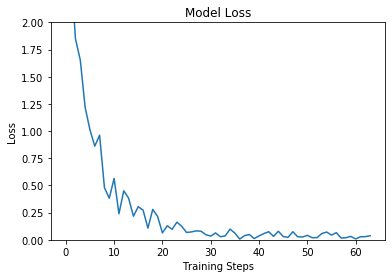

In [28]:
plt.figure()
plt.title('Model Loss')
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.show()

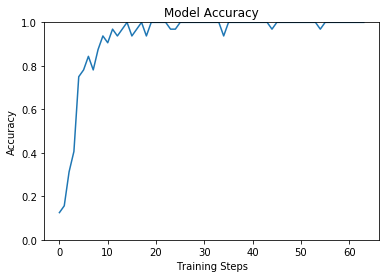

In [29]:
plt.figure()
plt.title('Model Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

# Predict test data

In [30]:
test_loss, test_acc = model.evaluate(test_data)
print("test loss: {:.2f}".format(test_loss))
print("test accuracy: {:.2f}".format(test_acc))

  ...
    to  
  ['...']
4/4 [==============================] - 11s 3s/step - loss: 0.0524 - acc: 0.9900
test loss: 0.05
test accuracy: 0.99


In [74]:
test_pred = None
test_true = None
batch = None
names_pred = None
batch_len = test_data.__len__()

for b in range(batch_len):
    test_batch, test_label = next(test_data)

    predicted_batch = model.predict(test_batch)
    predicted_id = np.argmax(predicted_batch, axis=-1)
    predicted_label = class_names[predicted_id]
    label_id = np.argmax(test_label, axis=-1)
    
    if b>0:
        test_pred = np.concatenate((test_pred, predicted_id), axis=0)
        test_true = np.concatenate((test_true, label_id), axis=0)
        batch = np.concatenate((batch, test_batch), axis=0)
        names_pred = np.concatenate((names_pred, predicted_label), axis=0)
    else:
        test_pred = predicted_id
        test_true = label_id
        batch = test_batch
        names_pred = predicted_label

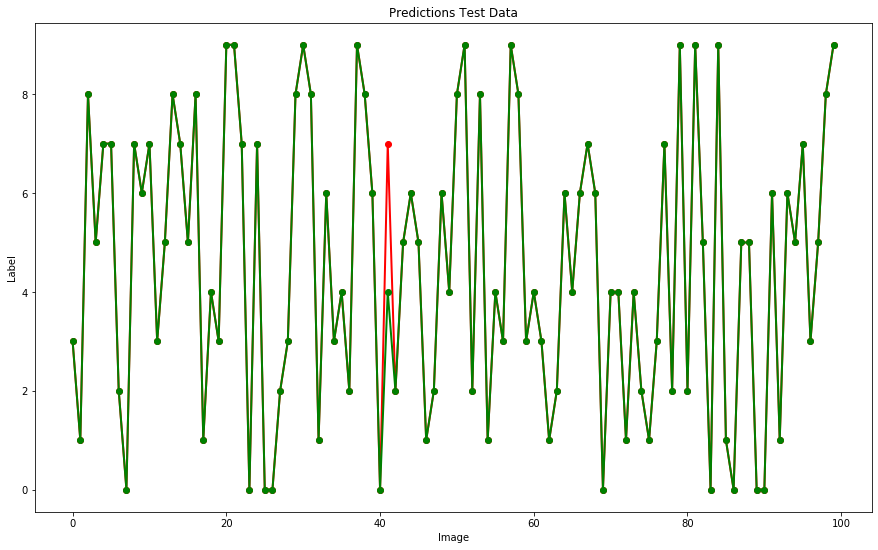

In [75]:
plt.figure(figsize=(15,9))
plt.title('Predictions Test Data')
plt.plot(test_pred, color='red', marker='o', linewidth=2, markersize=6)
plt.plot(test_true, color='green', marker='o', linewidth=2, markersize=6)
plt.xlabel('Image')
plt.ylabel('Label')
plt.show()

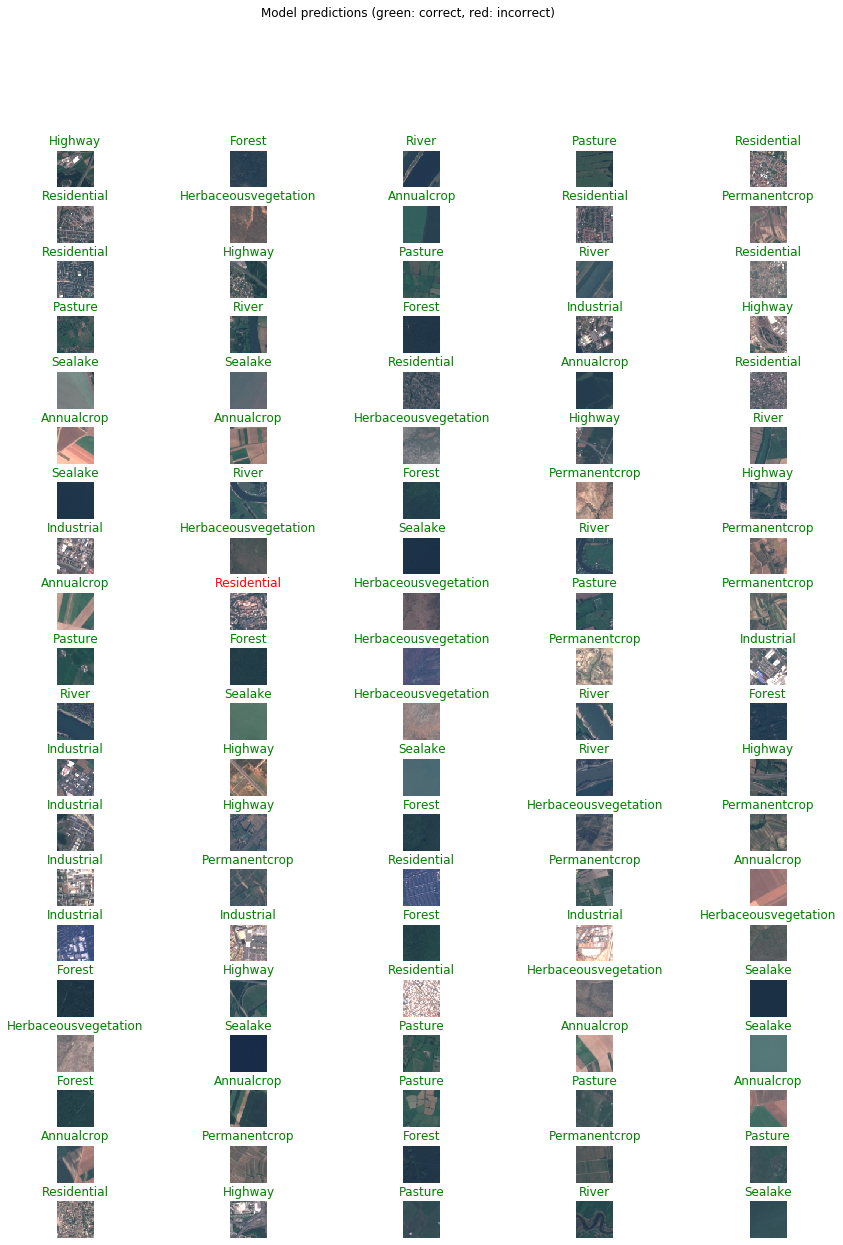

In [88]:
plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.5)
for n in range(100):
  plt.subplot(20,5,n+1)
  plt.imshow(batch[n])
  color = "green" if test_pred[n] == test_true[n] else "red"
  plt.title(names_pred[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [89]:
save_dir = r'D:\ML_Image\saved_model\MyEuroSat'
model.save(save_dir, save_format='tf')

INFO:tensorflow:Assets written to: D:\ML_Image\saved_model\MyEuroSat\assets


In [23]:
#reloaded = tf.keras.models.load_model(save_dir)